# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
    * The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.
 

## Inputs

* inputs/dataset/cherry-leaves/train
* inputs/dataset/cherry-leaves/test
* inputs/dataset/cherry-leaves/validation
* image shape embeddings 

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Confision matrix.
* Classification report.
* AUC - ROC curve.
* Prediction on the random image file.

---

# Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Set working directory

In [2]:
cwd = os.getcwd()
cwd

'/workspaces/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir('/workspaces/mildew-detection-in-cherry-leaves')
print("You set a new working directory")

You set a new working directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspaces/mildew-detection-in-cherry-leaves'

# Set Input Directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set Output Directories

In [6]:
version = 'v3'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


# Set Labels

In [7]:
labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['healthy', 'powdery_mildew']


# Set Image Shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v3'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(100, 100, 3)

---

# Number of Images in Train, Test and Validation Data

Count the number of images for each label in each data subset.

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images


## Image Distribution Bar Graph

Plot a bar graph to visualize the number of images per label in each set and save this plot in the output directory.

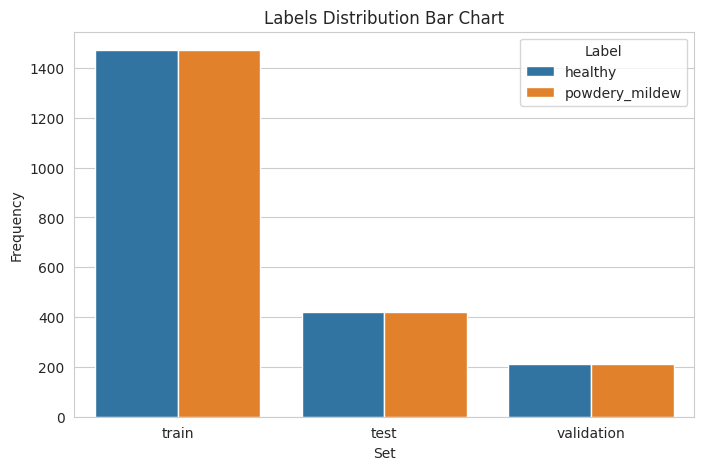

In [10]:
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.title('Labels Distribution Bar Chart')
plt.savefig(f'{file_path}/labels_distribution_bar.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image Distribution Pie Chart

Plot a pie chart to visualize the number of images in each set and save this plot in the output directory.

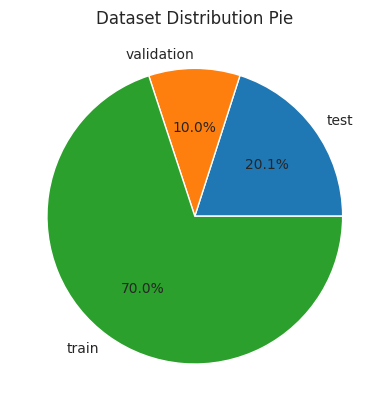

In [11]:
folders = os.listdir(my_data_dir)
freq=[]
set=[]
for folder in folders:
    set.append(folder)
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))*2
    freq.append(n)

plt.pie(x=freq, labels=set, autopct='%1.1f%%')
plt.title('Dataset Distribution Pie')
plt.savefig(f'{file_path}/data_distribution_pie.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image Data Augmentation
The dataset can be artificially expanded by augmenting images using the Keras class ImageDataGenerator. This class enables configuration of random transformations and normalization operations to be done on the image data during training and generation of batches of additional image data and their labels directly from the jpgs in their respective folders.

## Import ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Initialize ImageDataGenerator

The ImageDataGenerator function will be assigned to the `augmented_image_data` variable and intialized to perform the following augmentations:

* Randomly rotate images within a range of 0-40 degrees.
* Randomly translate images vertically by up to 10% of the total image height.
* Randomly translate images horizontally by up to 10% of the total image width.
* Randomly apply shearing transformations to distort the image along an axis, to a degree of 10%.
* Randomly zoom inside images to a degree of 10%.
* Randomly flip images horizontally.
* Randomly flip images vertically.
* Newly created or broken pixels, which can appear after a rotation or a width/height shift, will be filled in with the nearset pixel value.
* Pixel values will be rescaled to target values between 0 and 1 by scaling with a 1/255. factor. This helps to avoid pixel values that are too high for the model to process.

In [13]:
augmented_image_data = ImageDataGenerator(rotation_range=40,
                                          height_shift_range=0.10,
                                          width_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

## Augment Training Image Dataset

Apply `augmented_image_data` to the training set using the `flow_from_directory` function to fetch images directly from the training folder, transform each image width and height to the target image shape set during data analysis, set images to standard RBG color mode, set the batch number of images to augment, set `class_mode` to categorical to one-hot encode the labels for use with `categorical_crossentropy` loss function and shuffle the images. The resulting values will be assigned to the variable `train_set`.

Class indices are displayed to verify that images from both classes were augmented.

In [14]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Augment Validation and Test Image Datasets
Fetch images from the validation and test image datasets using `flow_from_directory` function with the same arguments used to fetch images from the train dataset, however the images will be augmented only by standardizing image pixels between 0 to 255 pixels using `ImageDataGenerator`.

Class indices are displayed to verify that images from both classes were augmented.

### Augment Validation Image Dataset

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment Test Image Dataset

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot Augmented Training Images
Plot three images from the augmented train dataset to view examples of the augmentations.

(20, 100, 100, 3)


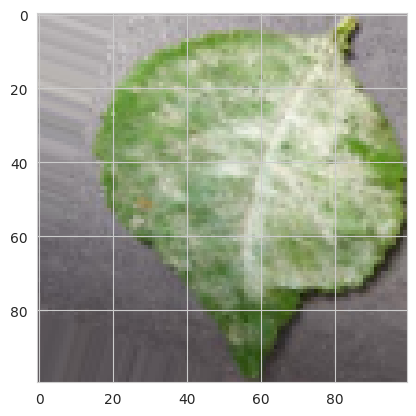

(20, 100, 100, 3)


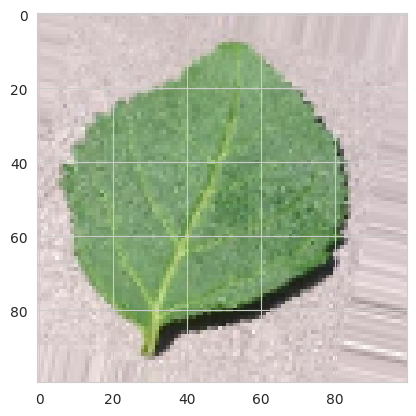

(20, 100, 100, 3)


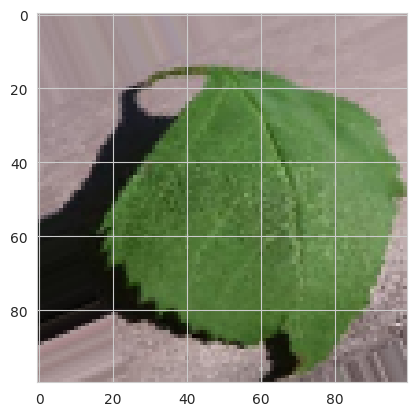

In [17]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Plot Augmented Validation and Test Images

(20, 100, 100, 3)


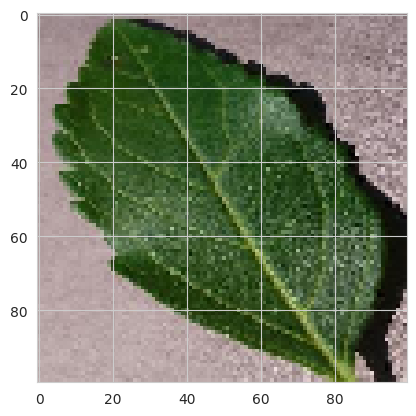

(20, 100, 100, 3)


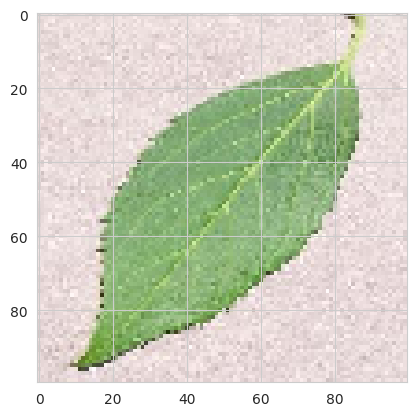

(20, 100, 100, 3)


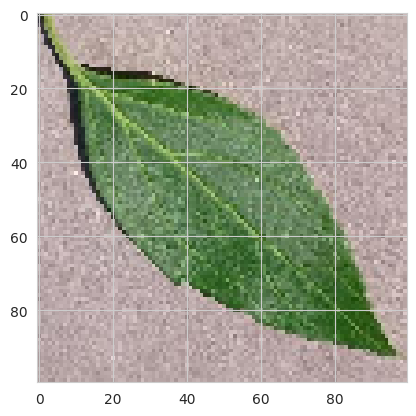

In [18]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

(20, 100, 100, 3)


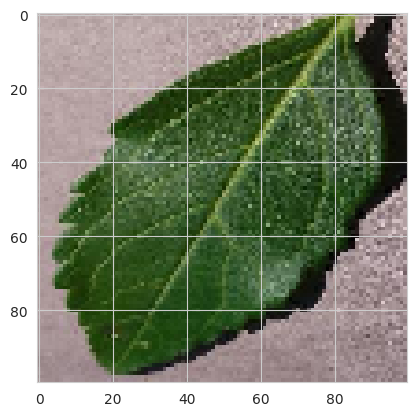

(20, 100, 100, 3)


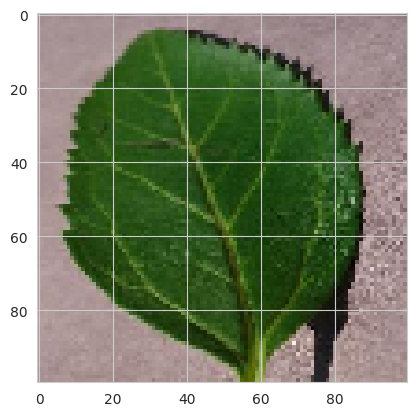

(20, 100, 100, 3)


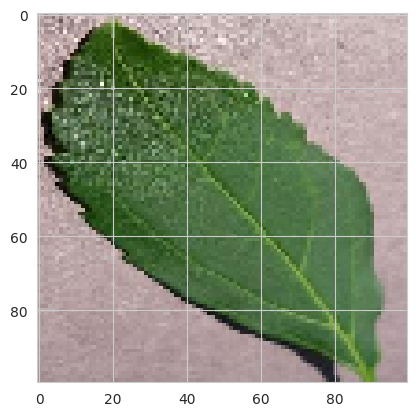

In [19]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Save class_indices
Save the class indices for both the labels into a pickle file for our further use.

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v3/class_indices.pkl']

---

# Model Creation

## Model Rationale When Defining Network Layers, Compiling the model and Setting Hyperparameters.
In this model the RMSprop optimizer replaced the Adam optimizer used in V2, to try to help stabalize the training process by normalizing the gradient and using and adaptive learning rate.

* [Sangvirajit (2021), A Complete Guide to Adam and RMSprop Optimizer](https://medium.com/analytics-vidhya/a-complete-guide-to-adam-and-rmsprop-optimizer-75f4502d83be)
* [Harpreet Sahota (2023), Intuitive Explanation of SGD, Adam, and RMSProp](https://www.kaggle.com/code/harpdeci/intuitive-explanation-of-sgd-adam-and-rmsprop#Train-with-RMSProp)

The design of the model developed in this project is based on the model architecture used in Code Institute's Malaria Detector walkthrough project. The model hyperparameters were optimized using KerasTuner in V2 model.

The Keras sequential class is used to group a linear stack of layers into a tf.keras.Model. A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. It also provides training and inference features on this model ([1], [2]).

The architecture of the model is structured into repeated modules of paired 2D convolution and pooling layers. This pattern creates feature maps with the convolution layer by performing 2-dimensional convolutions over the image data, and then downsamples the data with the pooling layer to help keep the feature maps to a reasonable size as the number of features grows. It also improves the models ability to generalize when making predictions as the features detected are summarized ([3]).

The input layer is a Conv2D layer. The values for the number of filters of 16 or 32 were chosen to be smaller values than for the subsequent convolution layers to allow the model to capture a smaller number of general features of the input data in the first convolution. This allows for the model to learn how these features relate to each other and more complex patterns made of the already extracted features in subsequent convolutions. The input convolution layer is followed by a MaxPooling2d layer to downsample the data ([3]).

The hidden layers start with a stack of Conv2D/MaxPooling2D modules, the number of which is tuned using KerasTuner. Stacked convolution layers are required to increase the model's capacity to learn complex patterns in the input data. The number of filters used in the hidden Conv2D layers is also tuned using KerasTuner, the possible values were chosen to increase the number of features extracted from output of the first convolution layer for learning complex patterns ([3]).

The convolution layers kernel size of 3 x 3 was chosen because it is a small kernel (> 4 x 4 is considered large) so it reduces computational costs and weight sharing that leads to lesser weights for back-propagation, compared to larger kernel sizes. An odd-sized filter symmetrically divides the previous layer pixels around the output pixel which avoids distortion across the layer. 1 x 1 kernel is not suitable as it would capture the interaction of input channels in only one pixel of the feature map which would result in extracted features being too finely grained and give no information from neighbouring pixels ([4]).

The Rectified Linear Unit (ReLu) activation function is used in the convolution layers. Advantages to using this function include it helping to make the neural network easier to optimize due to the ReLu function acting like a linear activation function. Also it is computationally simple and inexpensive to implement as it requires a max() function instead of requiring an exponential calculation ([5]).

The MaxPooling2D class is used for the pooling layers to downsample the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input ([6]). The function selects the brighter pixels from the image which is useful in this project as the points of interest in the data are areas of possible mildew which are a lighter colour compared to the colour of the leaf the mildew presents on ([7]). A pool_size of 2 x 2 was selected as this is a frequently used value, this will downsample the size of each feature map by a factor of 2 (the dimensions will be halved) ([3]).

The 3 dimensional output given by a Conv2D layer needs to be converted to  a1 dimensional vector in order for the proceding dense layer to be able to process it. This can be done using a Flatten layer between the convolution modules and the dense layer ([3]).

Dense layers are used to classify the image data based on the output of the convolution layers ([8]). The units of the first dense layer is optimized using KerasTuner with the possible values of 64 and 128, set with the goal of reducing the number of neurons (9).

A Dropout layer is used as a regularization technique with the goal of preventing overfitting and help to build a more robust and generalizable model. The dropout rate is optimized using KerasTuner using the possible values of 0.2 and 0.5 to test the minimum and maximum of the conventional range often used in models ([3]).

The second Dense layer is used as the output layer and a value of 2 is set as the units argument to end the network with 2 neurons (2 possible classes, healthy and powdery_mildew) and facilitate the use of the softmax activation function. The softmax activation was used as an alternative to the sigmoid function, which is equivalent to a 2-element softmax, where the second element is assumed to be zero. Softmax is often used as the activation for the last layer of a classification network because the result could be interpreted as a probability distribution ([10]).

As there are 2 classes that have been one-hot encoded and the softmax activation function is used in the output layer, the model is compiled with categorical_crossentropy defined as the loss function ([11]).

Adam was chosen as the optimizer because it is computationally efficient, it stores only the first and second moments of the gradients, keeping memory needs low. It also can still perform well even when the learning rate or other hyperparameters are not perfectly tuned ([12], [13]).

Accuracy is chosen as the metric to be monitored during training and testing, which will calculate how often predictions equal labels. This metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true ([14]).

[1]: https://keras.io/guides/sequential_model/
[2]: https://keras.io/2.15/api/models/sequential/
[3]: https://sourestdeeds.github.io/pdf/Deep%20Learning%20with%20Python.pdf
[4]: https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15
[5]: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
[6]: https://keras.io/2.15/api/layers/pooling_layers/max_pooling2d/
[7]: https://medium.com/@bdhuma/which-pooling-method-is-better-maxpooling-vs-minpooling-vs-average-pooling-95fb03f45a9
[8]: https://towardsdatascience.com/introduction-to-convolutional-neural-network-cnn-de73f69c5b83
[10]: https://keras.io/api/layers/activations/
[11]: https://keras.io/2.15/api/losses/probabilistic_losses/#categoricalcrossentropy-clas
[12]: https://builtin.com/machine-learning/adam-optimization
[13]: https://www.linkedin.com/pulse/mechanics-pros-cons-machine-learning-optimization-sofia-m%C3%A9ndez/
[14]: https://keras.io/2.15/api/metrics/accuracy_metrics/#accuracy-classs

1. Keras documentation, The Sequential model (https://keras.io/guides/sequential_model/)
2. Keras documentation, The Sequential Class (https://keras.io/2.15/api/models/sequential/)
3. Francois Chollet (2021), Deep Learning with Python (https://sourestdeeds.github.io/pdf/Deep%20Learning%20with%20Python.pdf)
4. Swarnima Pandey (2020), How to choose the size of the convolution filter or Kernel size for CNN? (https://medium.com/analytics-vidhya/how-to-choose-the-size-of-the-convolution-filter-or-kernel-size-for-cnn-86a55a1e2d15)
5. Jason Brownlee (2020), A Gentle Introduction to the Rectified Linear Unit (ReLU) (https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)
6. Keras documentation, MaxPooling2D layer (https://keras.io/2.15/api/layers/pooling_layers/max_pooling2d/)
7. Madhushree Basavarajaiah (2019), Maxpooling vs minpooling vs average pooling (https://medium.com/@bdhuma/which-pooling-method-is-better-maxpooling-vs-minpooling-vs-average-pooling-95fb03f45a9)
8. Govinda Dumane (2020), Introduction to Convolutional Neural Network (CNN) using Tensorflow (https://towardsdatascience.com/introduction-to-convolutional-neural-network-cnn-de73f69c5b83)
9. Code Institute TensorFlow Unit 10: Image Classification
10. Keras documentation, Layer activation functions (https://keras.io/api/layers/activations/)
11. Keras documentation, Probabilistic losses (https://keras.io/2.15/api/losses/probabilistic_losses/#categoricalcrossentropy-class
12. Rahul Agarwal (2023), Complete Guide to the Adam Optimization Algorithm (https://builtin.com/machine-learning/adam-optimization)
13. Sofia Mendez (2022), Mechanics and Pros & Cons of Machine Learning optimization techniques (https://www.linkedin.com/pulse/mechanics-pros-cons-machine-learning-optimization-sofia-m%C3%A9ndez/)
14. Keras documentation, Accuracy metrics (https://keras.io/2.15/api/metrics/accuracy_metrics/#accuracy-class))


Import Model Packages

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import keras_tuner

### Define Callbacks

`EarlyStopping` callback is used to stop training early if the model performance does not improve after a set number of epochs, in this case it was set to stop if the validation loss does not decrease after 5 epochs. It also restores the model weights of the best performing epoch.

`ReduceLROnPlateau` callback is used to reduce the model learning rate if the performance does not improve after a set number of epochs, in this case it was set to reduce the learning rate by a factor of 0.1 if the validation loss does not improve after 3 epochs with a miniumum learning rate of 0.001.

`Tensorboard` callback is used to enable the use of Tensorboard to view model training history and metrics, saving training logs to a directory in the workspace.

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=0.001)
tb = TensorBoard(f'{file_path}/tb_logs')

2024-02-13 05:21:50.318738: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-02-13 05:21:50.329712: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-02-13 05:21:50.629136: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


# Train the Model using the Optimized Hyperparameter Values

In [30]:
def build_opt_model():
    model = Sequential()

    model.add(Conv2D(32,
                     kernel_size=(3, 3),
                     input_shape=image_shape,
                     activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96,
                     kernel_size=(3, 3),
                     activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64,
                     kernel_size=(3, 3),
                     activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96,
                     kernel_size=(3, 3),
                     activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64,
                    activation='relu'))
    
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    return model

## Model Summary

In [31]:
build_opt_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 96)        27744     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 64)        55360     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 96)         

## Fit Model for Model Training

In [33]:
model = build_opt_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
         )

Epoch 1/25
147/147 [==============================] - 246s 2s/step - loss: 0.3951 - accuracy: 0.8119 - val_loss: 0.1561 - val_accuracy: 0.9381
Epoch 2/25
147/147 [==============================] - 257s 2s/step - loss: 0.1555 - accuracy: 0.9466 - val_loss: 0.0243 - val_accuracy: 0.9929
Epoch 3/25
147/147 [==============================] - 251s 2s/step - loss: 0.1009 - accuracy: 0.9685 - val_loss: 0.0487 - val_accuracy: 0.9857
Epoch 4/25
147/147 [==============================] - 272s 2s/step - loss: 0.0838 - accuracy: 0.9764 - val_loss: 0.0346 - val_accuracy: 0.9857
Epoch 5/25
147/147 [==============================] - 277s 2s/step - loss: 0.0617 - accuracy: 0.9819 - val_loss: 0.0623 - val_accuracy: 0.9810
Epoch 6/25
147/147 [==============================] - 277s 2s/step - loss: 0.0660 - accuracy: 0.9781 - val_loss: 0.1273 - val_accuracy: 0.9524
Epoch 7/25
147/147 [==============================] - 275s 2s/step - loss: 0.0806 - accuracy: 0.9822 - val_loss: 0.0134 - val_accuracy: 0.9952

## Save Model

In [34]:
model.save('outputs/v3/mildew_detector_model.h5')

---

# Model Performance

---

## Model Learning Curve

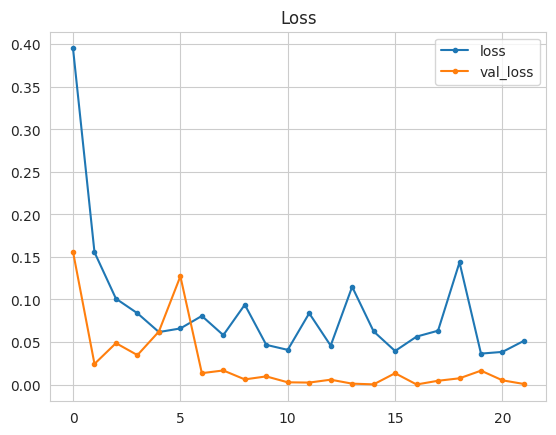

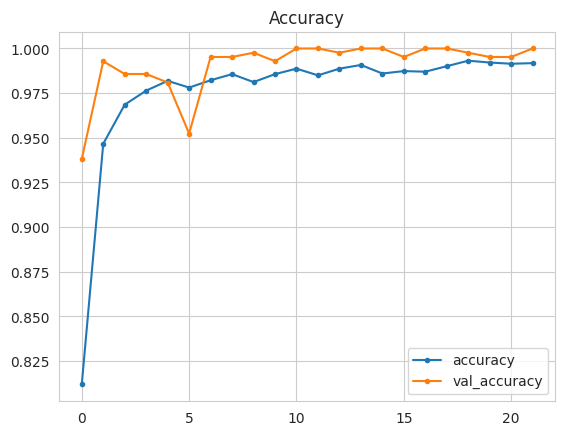

In [35]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

Load saved model.

In [36]:
from keras.models import load_model
model = load_model('outputs/v3/mildew_detector_model.h5')

Evaluate the model on the test set

* The performance on the test set meets the project requirements (at least 97% accuracy on test set)

In [37]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 22s 468ms/step - loss: 1.3390e-05 - accuracy: 1.0000


Save evaluation pickle

In [38]:
joblib.dump(value=evaluation,
            filename=f"outputs/v3/evaluation.pkl")

['outputs/v3/evaluation.pkl']

## Set Variable for Evaluation Report Charts

In [39]:
x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

## Confusion Matrix

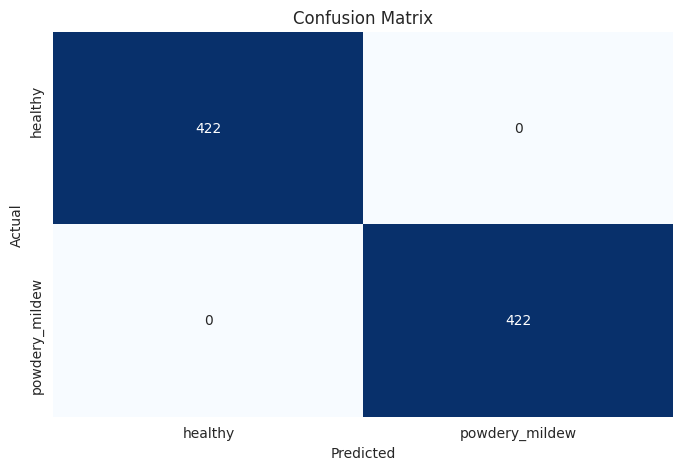

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, vmin=0, fmt='g', cmap='Blues', annot=True, cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=10)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=10)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

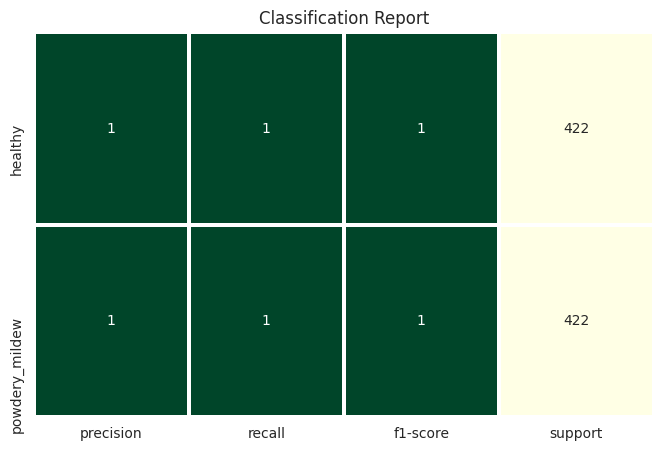

In [41]:
import matplotlib as mpl
from sklearn.metrics import classification_report

# Create pandas DataFrame
clf_report = classification_report(
    test_set.classes, y_pred, target_names=labels, output_dict=True)
df = pd.DataFrame(clf_report).T
df = df.drop({'accuracy', 'macro avg', 'weighted avg'})
df = df.sort_index(ascending=True)

# Plot heatmap and mask the support column
fig, ax = plt.subplots(figsize=(8, 5))
mask = np.zeros(df.shape)
mask[:, -1] = True
sns.heatmap(df,
            mask=mask,
            annot=True,
            cmap='YlGn',
            fmt='.3g',
            cbar=False,
            linewidths=.4,
            linecolor='white',
            vmin=0.0,
            vmax=1.0
           )

# Add support column and normalize the column colours
mask = np.zeros(df.shape)
mask[:, :-1] = True
sns.heatmap(df,
            mask=mask,
            annot=True,
            cmap='YlGn',
            fmt='.3g',
            cbar=False,
            linewidths=2,
            linecolor='white',
            vmin=df['support'].min(),
            vmax=df['support'].sum(),
            norm=mpl.colors.Normalize(vmin=df['support'].min(),
                                      vmax=df['support'].sum()
                                     )
           )

plt.title('Classification Report')
plt.savefig(f'{file_path}/classification_report.png',
            bbox_inches='tight', dpi=150)

## ROC Curve

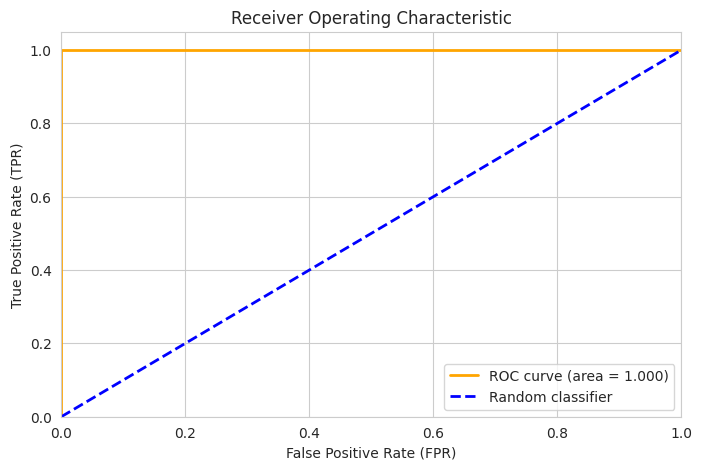

Area Under ROC-Curve:  1.0


In [42]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

sns.set_style("whitegrid")
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
plt.plot(fpr,
         tpr,
         color='orange',
         lw=2,
         label='ROC curve (area = %0.3f)' % roc_auc
)
plt.plot([0, 1],
         [0, 1],
         color='blue',
         lw=2,
         label="Random classifier",
         linestyle='--'
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(f'{file_path}/roc_curve.png',
            bbox_inches='tight', dpi=150)
plt.show()
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))

# Predict On New Data

Load an image as PIL to test the model

Image shape: (100, 100), Image mode: RGB


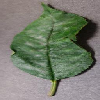

In [43]:
from tensorflow.keras.preprocessing import image

pointer = 32
label = labels[1] # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [44]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


In [45]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)
print(f"{pred_class} {round(pred_proba*100, 2)}%")

0.999999999999991
powdery_mildew
powdery_mildew 100.0%


---

# Conclusions

Accuracy/Loss Curves
* The accuracy curve suggests that the model was able to learn from the data to make increasingly accurate class predictions as training progressed, this is shown by the plotted lines following a similar path and being close to each other.
* The loss curve suggests that the validation data may have been easier for the model to learn than the training data, this is shown by the eratic values of the train loss compared to the more stable line plotted for the validation loss.

Model Performance Evaluation
* The evaluation of the model over the data test set gave a generalized loss of approximately 0.00001% and accuracy of 100%, which more than satisfies the clients requirement of 97% accuracy.

Confusion Matrix.
* The confusion matrix plot shows that when testing the model with the test set; all 422 healthy leaves were correctly predicted to be healthy, 0 healthy leaves were incorrectly predicted to be mildew infected, and all 422 mildew infected leaves were correctly predicted to be mildew infected, no mildew infected leaves were incorrectly predicted to be healthy.

Classification Report
* Recall/sensitivity rate is the percentage of the class that was properly predicted. The classification report shows that 100% of the healthy leaf images were correctly predicted as healthy and 100% of the mildew infected leaf images were correctly predicted as infected.
* Precision is the percentage of predictions related to a class made were correct, or how many predictions of a certain class were correct compared to the total number of predictions of that class. The classification report shows that the 100% of the healthy class predictions made were correct and 100% of the powdery_mildew class predictions were correct.
* The f1-score measures Recall and Precision together using Harmonic Mean. It give the average value for Recall and Precision.

ROC Curve
* ROC (Receiver Operating Characteristic) is a probability curve and is used to calculate the AUC (Area Under Curve) value. The AUC value represents the degree or measure of separability, which is the models capability to distinguish between classes. The AUC value achieved in this evaluation report shows that the model has a high capability to distinguish between classes.